# Monte Carlo Pricing with Time Discretization (Asian Option)

This notebook introduces time discretization in Monte Carlo simulation to generate full price paths of the underlying asset. This is necessary for pricing path-dependent options such as the Asian option, which depends on the average price over time rather than only the terminal price.

## Objectives
- Implement multi-step simulation of Geometric Brownian Motion (GBM)
- Price an Asian call option using Monte Carlo simulation
- Compare pricing performance with different numbers of time steps
- Discuss limitations and possible improvements

The continuous-time GBM model:
$$ dS_t = r S_t\, dt + \sigma S_t \, dW_t $$

Discretized using Euler–Maruyama:
$$ S_{t+\Delta t} = S_t \cdot \exp\left((r - 0.5\sigma^2)\Delta t + \sigma \sqrt{\Delta t} Z\right), \quad Z \sim N(0,1) $$

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np

In [3]:
S0 = 100
K = 105
r = 0.05
sigma = 0.2
T = 1.0          # maturity (1 year)
n_sim = 20000    # number of simulation paths
n_steps = 252    # number of time steps (e.g., trading days)
seed = 42

In [4]:
def simulate_gbm_path(S0, r, sigma, T, n_steps, n_sim, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / n_steps
    Z = np.random.normal(0, 1, (n_sim, n_steps))
    
    paths = np.zeros((n_sim, n_steps + 1))
    paths[:, 0] = S0
    
    for t in range(1, n_steps + 1):
        paths[:, t] = paths[:, t-1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1]
        )

    return paths

In [5]:
paths = simulate_gbm_path(S0, r, sigma, T, n_steps, n_sim, seed)
paths.shape

(20000, 253)

In [6]:
# Asian Call Option payoff: average price over the path
def price_asian_call_mc(paths, K, r, T):
    avg_price = np.mean(paths[:, 1:], axis=1)  # exclude S0 if preferred
    payoffs = np.maximum(avg_price - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

asian_call_price = price_asian_call_mc(paths, K, r, T)
asian_call_price

np.float64(3.498356357339908)

In [7]:
# For benchmarking only
from src.option_pricing import price_european_call_mc

european_price = price_european_call_mc(S0, K, r, sigma, T, n_sim, seed)

print(f"Asian Call Price (Monte Carlo): {asian_call_price:.4f}")
print(f"European Call Price (Monte Carlo): {european_price:.4f}")
print("Difference:", abs(asian_call_price - european_price))

Asian Call Price (Monte Carlo): 3.4984
European Call Price (Monte Carlo): 8.0915
Difference: 4.5930955717268525


In [8]:
import time

def test_steps_effect(steps_list, n_sim=20000):
    for step in steps_list:
        start = time.time()
        paths = simulate_gbm_path(S0, r, sigma, T, step, n_sim, seed)
        price = price_asian_call_mc(paths, K, r, T)
        duration = time.time() - start
        print(f"Steps: {step:4d}, Price: {price:.4f}, Runtime: {duration:.3f}s")

steps_test_list = [50, 100, 252, 500, 1000]
test_steps_effect(steps_test_list)

Steps:   50, Price: 3.5431, Runtime: 0.059s
Steps:  100, Price: 3.5229, Runtime: 0.041s
Steps:  252, Price: 3.4984, Runtime: 0.102s
Steps:  500, Price: 3.4557, Runtime: 0.224s
Steps: 1000, Price: 3.4832, Runtime: 0.487s


### Visualization Notes

The stock price paths illustrate the randomness in trajectory driven by Brownian motion.  
Since Asian options depend on the **average** price across the path rather than only the terminal value, the payoff distribution tends to be smoother and less volatile compared to European options.

This justifies why Asian options are generally cheaper: averaging mitigates the effect of extreme price movements near maturity.

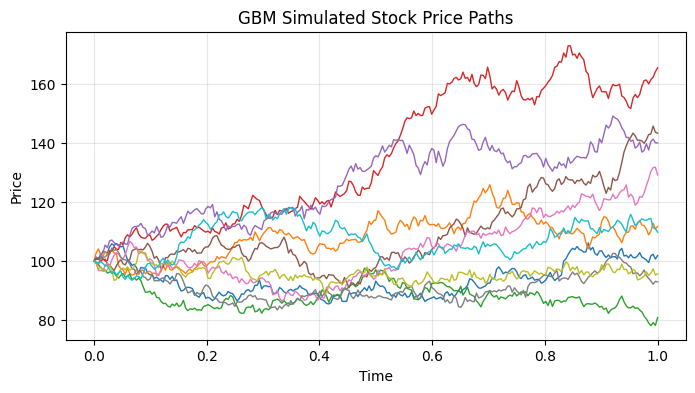

In [9]:
import matplotlib.pyplot as plt

# Select a subset of paths for plotting
n_plot = 10  # number of sample paths to display
time_grid = np.linspace(0, T, n_steps + 1)

plt.figure(figsize=(8, 4))
for i in range(n_plot):
    plt.plot(time_grid, paths[i], linewidth=1)

plt.title("GBM Simulated Stock Price Paths")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.show()

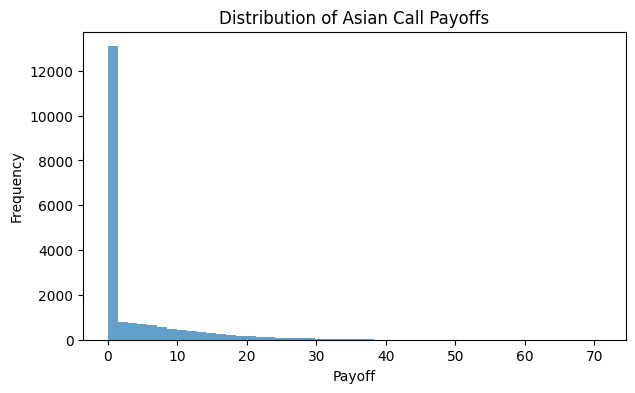

In [10]:
avg_price = np.mean(paths[:, 1:], axis=1)
payoffs = np.maximum(avg_price - K, 0)

plt.figure(figsize=(7, 4))
plt.hist(payoffs, bins=50, alpha=0.7)
plt.title("Distribution of Asian Call Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.show()